## **KIN 6015 Biomechanics**
**Lab 1 Data Processing**

In this lab, gait analysis data was collected with the marker-based and markerless motion capture systems and spatiotemporal metrics and inverse kinematics (IK) were estimated using Visual3D. The data were then exported as text (*.txt) files and uploaded to the class repository in the lab's [GitHub](https://github.com/plnu-biomechanics).

To further process the data for this lab, follow the steps in this **Colab notebook**, which contains instructions and sample code on how to wrangle and analyze the data.


### Create your own Colab Notebook

1. Go to **File -> New notebook in Drive** to open a new notebook in your Python environment:<br>
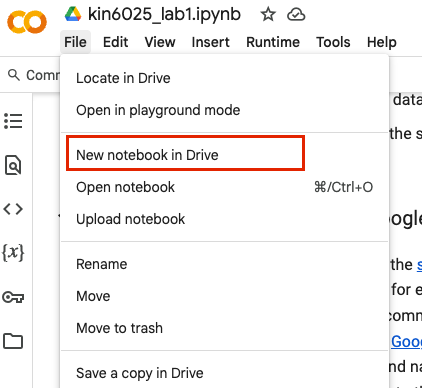
2. Rename your Colab notebook using this naming format: **lastname_group_lab#.ipynb **(e.g., "aguinaldo_targaryen_lab1.ipynb")
3. Click on the **+ Code** option above to insert a new code cell: <br>
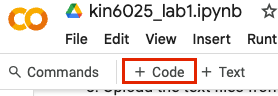
4. The data you will parse and analyze for this lab will be copied from the lab's GitHub and temporarily stored in your Colab working directory, which can be accessed by clicking on the folder icon in the left menu:
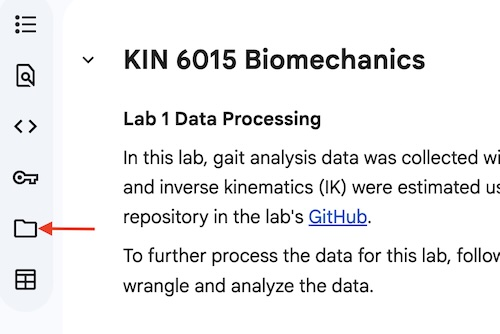

5. Copy the following lines of code to import the packages needed for this analysis and to load the data files into your working directory. Be sure to update the `GROUP` variable with your group's name. **Note**: These files are "runtime" access only, meaning they are only temporarily stored in your working directory and show up when your notebook is in session. However, the following code cell allows you to clone the zipped files to the working directory each time it is executed.


In [1]:
import urllib.request
import zipfile
import os

# --------------------------------------------------
# STUDENT INPUT (edit only this line; case-sensitive)
# --------------------------------------------------
GROUP = "targaryen"   # e.g., "targaryen", "stark", "lannister", "martel"

# --------------------------------------------------
# Configuration (do NOT edit below)
# These lines create a directory for this lab in your
# Colab working directory.
# --------------------------------------------------
zip_dir = "kin6015/lab1"
os.makedirs(zip_dir, exist_ok=True)

zip_filename = f"spring2026_lab1_{GROUP}.zip"

url = (
    "https://raw.githubusercontent.com/"
    "plnu-biomechanics/kin6015/main/"
    f"labs/{zip_filename}"
)

zip_path = os.path.join(zip_dir, zip_filename)

# --------------------------------------------------
# Download zip file
# --------------------------------------------------
urllib.request.urlretrieve(url, zip_path)

# --------------------------------------------------
# Extract contents
# --------------------------------------------------
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(zip_dir)

print("Extracted files in lab directory:")
print(os.listdir(zip_dir))


Extracted files in lab directory:
['Targaryen_MB_05.txt', 'Targaryen_ML_03.txt', 'Targaryen_ML_01.txt', 'Targaryen_ML_05.txt', 'Targaryen_MB_03.txt', 'spring2026_lab1_targaryen.zip', 'Targaryen_MB_01.txt', 'Targaryen_ML_04.txt', 'Targaryen_MB_04.txt', 'Targaryen_MB_02.txt', 'Targaryen_ML_02.txt']


### Calculate Summary Statistics

Now we can generate code to calculate summary statistics with boxplots and an APA formatted table.

1. Use GenAI to generate code that calculates summary statistics for each variable by condition.
2. Ask GenAI to include code that organizes the statistics in an APA formatted table.


          plantarflexion                                                     \
                   count       mean       std       min       25%       50%   
condition                                                                     
barefoot             5.0 -18.882226  3.001729 -22.26815 -20.38117 -19.01903   
shod                 5.0 -19.206896  2.970155 -23.87983 -19.40905 -19.34490   

                              grf_z               ... quad_emg           \
                75%       max count         mean  ...      75%      max   
condition                                         ...                     
barefoot  -18.57399 -14.16879   5.0  2336.253612  ...  0.68653  0.69539   
shod      -17.34281 -16.05789   5.0  2355.136914  ...  0.76894  0.84244   

          gastroc_emg                                                          \
                count      mean       std      min      25%      50%      75%   
condition                                                         

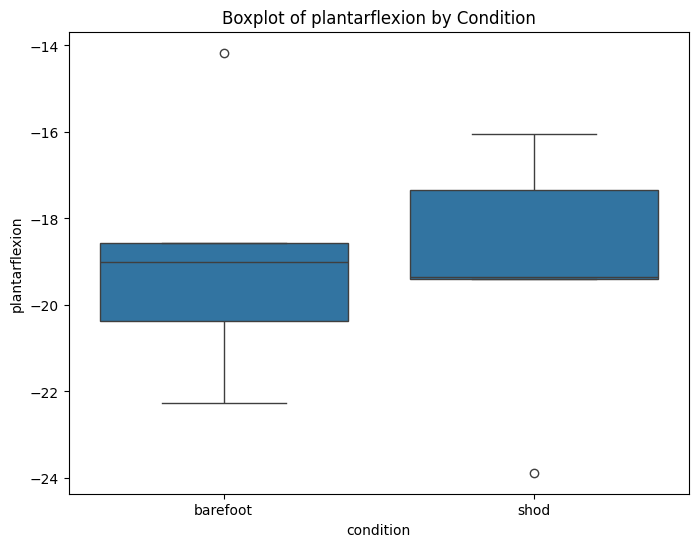

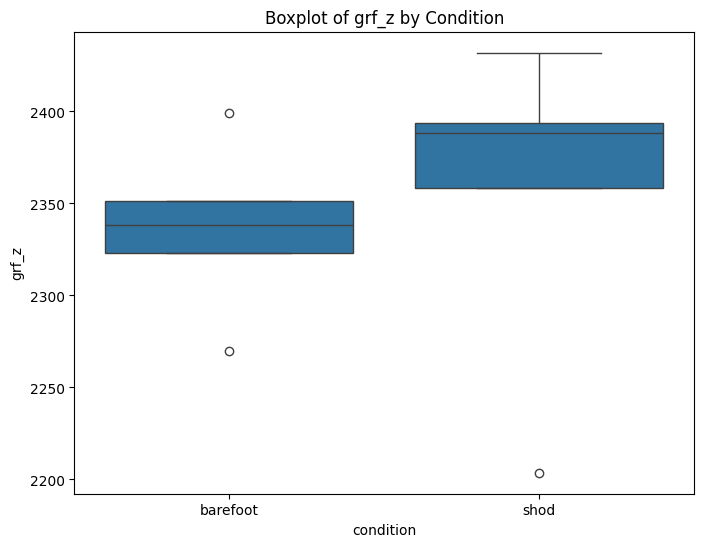

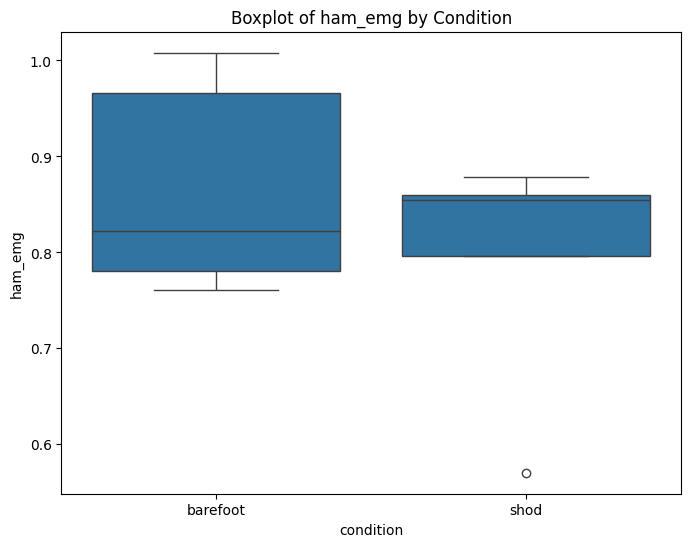

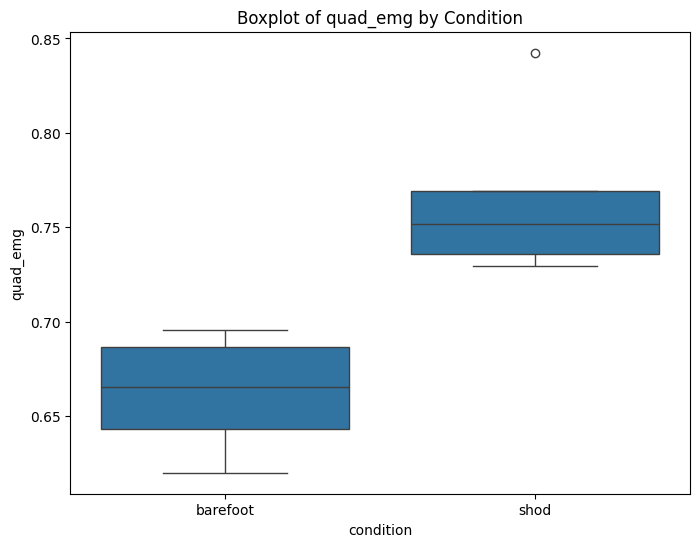

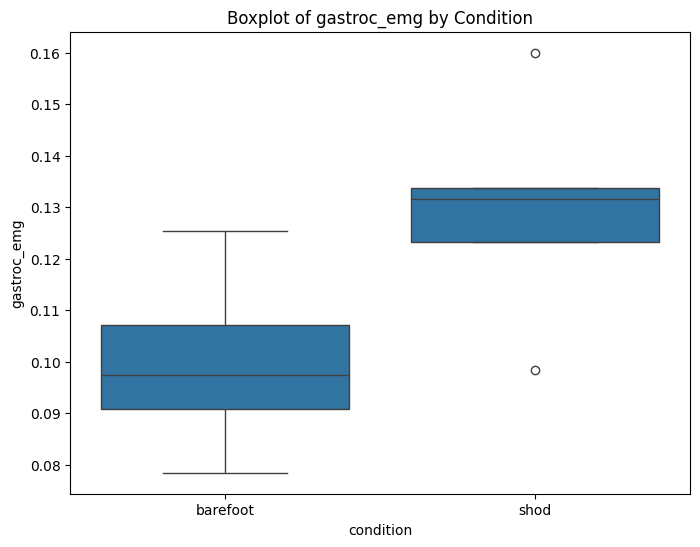

In [ ]:
# prompt: Calculate summary statistics for each variable grouped by condition. Generate boxplots of each variable.

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate summary statistics grouped by condition
summary_stats = df.groupby('condition').describe()
print(summary_stats)

# Generate boxplots for each variable
for column in df.columns:
  if column != 'condition':
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='condition', y=column, data=df)
    plt.title(f'Boxplot of {column} by Condition')
    plt.show()


In [ ]:
# prompt: Generate code that organizes the summary statistics in an APA formatted table

# Assuming summary_stats is the DataFrame with the descriptive statistics
# We will create a nicely formatted table in APA style

def create_apa_table(summary_stats):
  """Generates an APA-formatted table from the summary statistics."""

  # Extract relevant statistics for the table
  table_data = summary_stats[[
      ('plantarflexion', 'mean'), ('plantarflexion', 'std'),
      ('grf_z', 'mean'), ('grf_z', 'std'),
      ('ham_emg', 'mean'), ('ham_emg', 'std'),
      ('quad_emg', 'mean'), ('quad_emg', 'std'),
      ('gastroc_emg', 'mean'), ('gastroc_emg', 'std')
  ]]

  # Transpose the table for better formatting
  # table_data = table_data.transpose()

  # Rename columns to make it APA-compliant
  table_data = table_data.rename(
      index={
          'barefoot': 'Barefoot',
          'shod': 'Shod'
      },
      columns={'condition': 'Condition',
               'plantarflexion': 'Plantar Flexion',
               'grf_z': 'GRFz',
               'ham_emg': 'HAM EMG',
               'quad_emg': 'Quad EMG',
               'gastroc_emg': 'Gastroc EMG'
      }
      )

  # Format the table with significant digits
  table_data = table_data.map(lambda x: f"{x:.2f}" if isinstance(x, float) else x)

  # Print the table in a formatted way
  print("Table 1. Summary Statistics for Variables by Condition")
  print("----------------------------------------------------")
  print(table_data.to_string())


# Call the function to generate the table
create_apa_table(summary_stats)


Table 1. Summary Statistics for Variables by Condition
----------------------------------------------------
          Plantar Flexion           GRFz        HAM EMG       Quad EMG       Gastroc EMG      
                     mean   std     mean    std    mean   std     mean   std        mean   std
condition                                                                                     
Barefoot           -18.88  3.00  2336.25  46.85    0.87  0.11     0.66  0.03        0.10  0.02
Shod               -19.21  2.97  2355.14  88.63    0.79  0.13     0.77  0.05        0.13  0.02


### Complete the Analysis

After you've completed this lab's analysis, do the following:

1. Copy and paste the above plots and tables to your lab report
2. Share your Colab notebook with me
3. Copy the link to your notebook and submit it along with your report for this lab on Canvas